<a href="https://colab.research.google.com/github/Dominic-DallOsto/translational-neuromodelling-mdd/blob/master/Classifier/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classifying MDD Patients

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from google.colab import drive
from scipy.io import loadmat
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# mount your google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
root_path = "/content/drive/MyDrive/translational-neuromodelling-mdd/"
A_mat_dir = "A_mats/"
corr_dir = "corr/"

# Get a list for .mat files in current folder
# Choose A_mat_dir for rDCM output, or corr_dir for correlation components
mat_files = glob.glob(root_path + A_mat_dir + '*.mat') 

# Import patient info
participants = pd.read_table(root_path + 'participants.tsv')
participants = participants.dropna()

# List for stroring all the data and labels
X = []
y = []

# Iterate mat files
for fname in tqdm(mat_files):
    # Load mat file data into data.
    data = loadmat(fname)
    id = int(os.path.basename(fname).split('.')[0][-4:]) - 1

    # Append data to the list
    X.append(data["A"])

    # Append diag label
    if participants["diag"][int(id)] == 2: # MDD
      y.append(0)
    elif participants["diag"][int(id)] == 0: # control
      y.append(1)
    else:
      print("ID: ", id)
      print("Diag: ", participants["diag"][int(id)])

100%|██████████| 124/124 [00:01<00:00, 79.61it/s]


In [84]:
X = np.array(X) # Convert list of X into numpy array
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny)) # Convert 3D matrix to 2D input vector
X_train = X[:100]
X_test = X[100:]
y_train = y[:100]
y_test = y[100:]

(377, 377)

## Lasso

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients

In [56]:
from sklearn import linear_model

In [85]:
# Run CV on Lasso classifier for alpha parameter optimisation
# Source: https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{'alpha': alphas}]
n_folds = 5
lasso = linear_model.Lasso(random_state=0, max_iter=10000)
clf = GridSearchCV(lasso, param_grid=tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

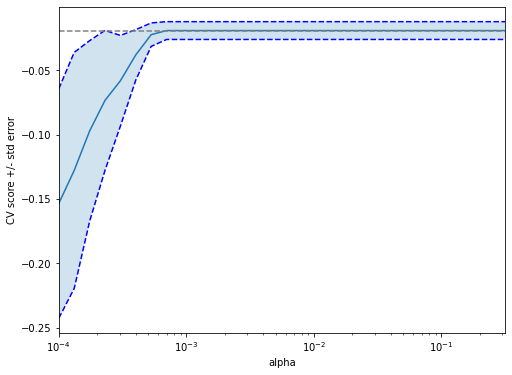

In [86]:
# Plot the CV results

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [93]:
clf = linear_model.Lasso(alpha=10e-1, max_iter=10000)
clf.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [94]:
clf.score(X_test, y_test)

-0.0439314285714285

## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [95]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test)

0.6666666666666666

In [106]:
data = {'Real':  y_test,
        'Pred': preds}

df = pd.DataFrame (data, columns = ['Real','Pred'])

print (df)

    Real  Pred
0      1     1
1      0     0
2      0     0
3      0     0
4      0     0
5      0     0
6      1     0
7      1     1
8      1     1
9      1     0
10     1     0
11     0     1
12     1     1
13     0     0
14     1     0
15     0     0
16     1     1
17     1     0
18     0     0
19     1     1
20     1     0
21     0     0
22     1     1
23     1     0


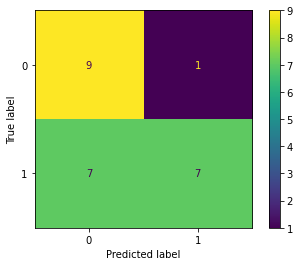

In [110]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot() 

## CNN

Following this tutorial: https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697

In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
train = ImageDataGenerator()
test = ImageDataGenerator()

train_dataset = train.flow_from_directory("C:/Users/ksbal/Desktop/CodeBasicML/PetImages/Train/",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("C:/Users/ksbal/Desktop/CodeBasicML/PetImages/Test/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

In [ ]:
# Check your encoded class labels
test_dataset.class_indices

In [ ]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(269,269,1)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for MDD or 1 for Control
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#steps_per_epoch = train_imagesize/batch_size

model.fit_generator(train_dataset,
         steps_per_epoch = 250,
         epochs = 10,
         validation_data = test_dataset)

In [ ]:
model.predict()